In [65]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
import scipy.constants as const
import pandas as pd
plt.style.use('../report.mplstyle')

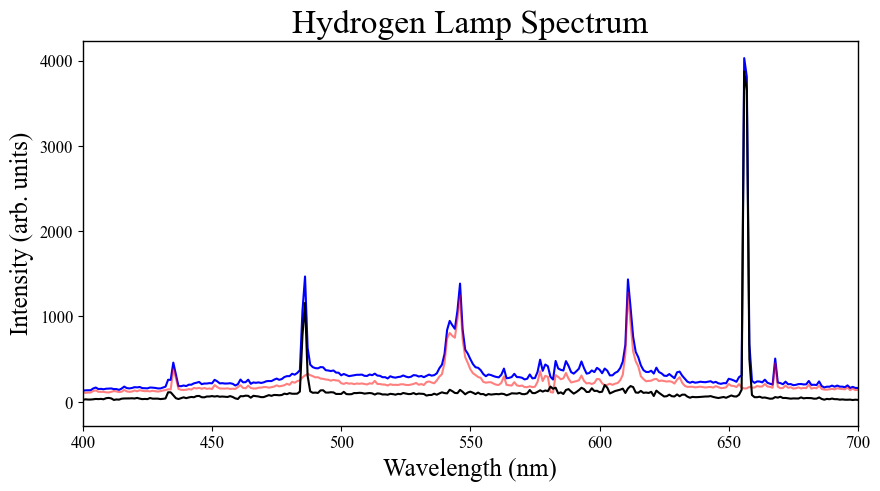

In [66]:
h_lamp = np.loadtxt('data/H_lamp/H_lamp0.txt', delimiter='\t', skiprows = 17, max_rows = 600)
background = np.loadtxt('data/H_lamp/H_lamp_background0.txt', delimiter='\t', skiprows = 17, max_rows = 600)

h_lamp_cor = h_lamp[:,1] - background[:,1]

plt.figure(figsize=(10,5))

plt.plot(h_lamp[:,0], h_lamp[:,1],color = 'blue')
plt.plot(background[:,0], background[:,1], color = 'red',alpha = 0.5)
plt.plot(h_lamp[:,0], h_lamp_cor, color = 'black')
plt.xlabel('Wavelength (nm)')
plt.xlim(400,700)
plt.ylabel('Intensity (arb. units)')
plt.title('Hydrogen Lamp Spectrum')
plt.show()



In [68]:
peaks,peaks_height = find_peaks(h_lamp_cor, height = 45, distance = 22, prominence = 0.1)
peaks = [peaks[0],peaks[1],peaks[3],peaks[9]]
peaks_height = [peaks_height['peak_heights'][0],peaks_height['peak_heights'][1],peaks_height['peak_heights'][3],peaks_height['peak_heights'][9]]


balmer_series = (h_lamp[peaks,0], peaks_height)
wavenumber = 1/(balmer_series[0]*1e-9)
balm_freq = const.c/balmer_series[0]*1e-9
energy = const.h*balm_freq
balmer_num = np.array([3,4,5,6])
df = pd.DataFrame(balmer_series,wavenumber,balm_freq,energy,balmer_num)

ValueError: Length of values (2) does not match length of index (4)